Desempenho no Teste-Cego (MAPE): 13.2602%


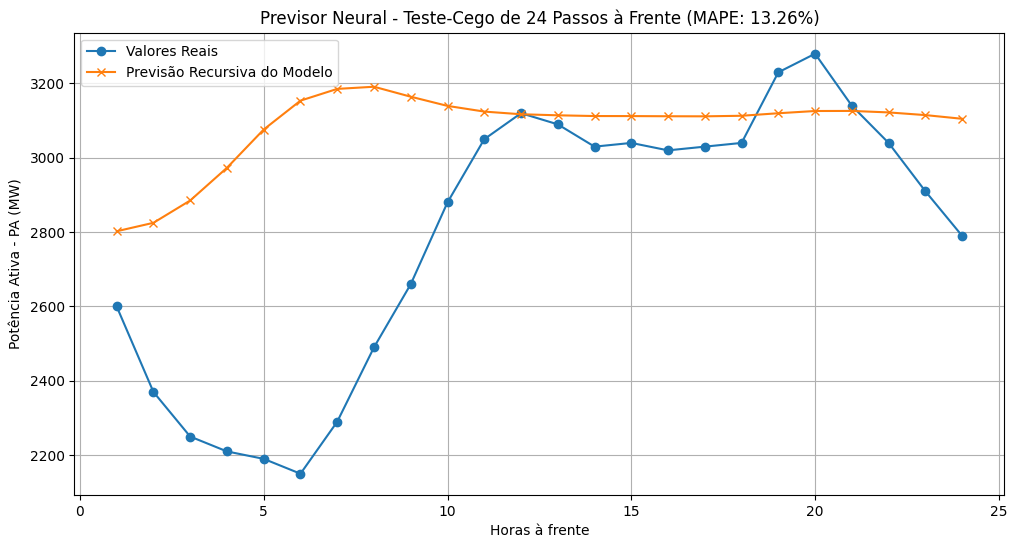

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

# 1. Carregamento dos Dados
# Substitua o caminho do arquivo pelo nome correto na sua máquina
arquivo = 'carga_eletrica.xlsx'
df = pd.read_excel(arquivo)
dados_pa = df['PA(MW)'].values

# 2. Pré-processamento e Escalonamento
# Redes Neurais convergem melhor com dados normalizados (entre 0 e 1)
scaler = MinMaxScaler()
dados_pa_escalonados = scaler.fit_transform(dados_pa.reshape(-1, 1)).flatten()

# 3. Montagem da Janela de Entradas e Saídas
# O previsor exige entradas: PA(k-1), PA(k-2), PA(k-24) para prever PA(k)
X = []
y = []

# Precisamos iniciar a partir do índice 24, onde temos histórico suficiente para k-24
for k in range(24, len(dados_pa_escalonados)):
    # Entradas do modelo: [PA(k-1), PA(k-2), PA(k-24)]
    x_k = [dados_pa_escalonados[k-1], dados_pa_escalonados[k-2], dados_pa_escalonados[k-24]]
    y_k = dados_pa_escalonados[k]
    X.append(x_k)
    y.append(y_k)

X = np.array(X)
y = np.array(y)

# 4. Divisão em Treinamento e Teste-cego
# Reservaremos as últimas 24 horas (passos) da série para o teste cego.
n_passos = 24
X_treino, y_treino = X[:-n_passos], y[:-n_passos]
X_teste, y_teste = X[-n_passos:], y[-n_passos:]
valores_reais_teste = dados_pa[-n_passos:] # Valores originais (não escalonados) para comparar

# 5. Treinamento da Rede Neural (MLPRegressor)
# Você pode testar outras configurações de 'hidden_layer_sizes'
mlp = MLPRegressor(hidden_layer_sizes=(15, 10),
                   activation='relu',
                   solver='adam',
                   max_iter=1500,
                   random_state=42)
mlp.fit(X_treino, y_treino)

# 6. Previsão Recursiva (1 a 24 passos à frente)
# A previsão precisa ser feita de forma que o previsor use as próprias previsões que gerou.
historico = list(dados_pa_escalonados[:-n_passos])
previsoes_escalonadas = []

for i in range(n_passos):
    # O tamanho atual do histórico reflete o instante k
    k_1 = historico[-1]
    k_2 = historico[-2]
    k_24 = historico[-24]

    # Prepara entrada para a hora atual
    x_input = np.array([[k_1, k_2, k_24]])

    # Realiza predição e guarda valor
    predicao = mlp.predict(x_input)[0]
    previsoes_escalonadas.append(predicao)

    # Adiciona a predição ao histórico, para ser o "k-1" da próxima iteração
    historico.append(predicao)

# Reverte as predições para a escala original (MW)
previsoes = scaler.inverse_transform(np.array(previsoes_escalonadas).reshape(-1, 1)).flatten()

# 7. Cálculo do Índice de Desempenho (MAPE)
mape = mean_absolute_percentage_error(valores_reais_teste, previsoes)
print(f"Desempenho no Teste-Cego (MAPE): {mape:.4%}")

# 8. Visualização Gráfica e Exportação de Resultados
plt.figure(figsize=(12, 6))
plt.plot(range(1, 25), valores_reais_teste, label='Valores Reais', marker='o')
plt.plot(range(1, 25), previsoes, label='Previsão Recursiva do Modelo', marker='x')
plt.title(f'Previsor Neural - Teste-Cego de 24 Passos à Frente (MAPE: {mape:.2%})')
plt.xlabel('Horas à frente')
plt.ylabel('Potência Ativa - PA (MW)')
plt.legend()
plt.grid(True)
plt.show()

# Opcional: Salva uma tabela em formato CSV com as previsões e os valores reais para análise no Excel
resultados_df = pd.DataFrame({
    'Hora_Frente': range(1, 25),
    'PA_Real_MW': valores_reais_teste,
    'PA_Prevista_MW': previsoes.round(2)
})
resultados_df.to_csv('resultados_previsao_24h.csv', index=False)